# Display test results for all blends

This notebook displays the results for deblending a set of blends with different source initialization methods. Once all of the blends have been run, the notebook displays the number of iterations each initialization took for each blend and the total residual.

In [1]:
# Import Packages and setup
import logging
import os

import numpy as np
import scarlet
import scarlet.display
from scarlet import modeling

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='magma')
matplotlib.rc('image', interpolation='none')

In [2]:
def deblend(idx):
    iterations2 = {}
    iterations3 = {}
    residuals2 = {}
    residuals3 = {}
    
    datapath = "/Users/fred/lsst/data/psf_test/deep"
    filter_indices = [2, 1, 0]
    stretch = .5
    Q = 10

    filename = "blend_{0}.npz".format(idx)
    print("loading data from'{0}'".format(os.path.join(datapath, filename)))
    data = np.load(os.path.join(datapath, filename))

    images = data["image"].astype(float)
    mask = data["mask"]
    variance = data["variance"]
    weights = 1/variance
    psfs = data["psf"].astype(float)
    peaks = data["peaks"]

    # Estimate the background RMS
    bg_rms = np.ones((len(psfs),), dtype=images.dtype) * .1

    # Initialize the observations and model frame
    target_psf = scarlet.psf.generate_psf_image(scarlet.psf.gaussian, shape=psfs[0].shape, amplitude=1, sigma=.8)
    frame = scarlet.Frame(images.shape, psfs=target_psf[None], dtype=float)
    observation = scarlet.Observation(images, psfs).match(frame, inverse=False)
    observation_deconvolved = scarlet.Observation(images, psfs).match(frame, inverse=True)

    window = scarlet.fft.symmetric_window(scarlet.fft.tukey_window, psfs.shape[1:], alpha=.9)
    observation_windowed = scarlet.Observation(images, psfs).match(frame, inverse=True, window=window)

    # Since PSFs are best fit as a sum of gaussians, fit the PSFs to a mixture of
    # two gaussians and only use the central gaussian for calculating moments
    psf_moments = {}
    for bidx, psf in enumerate(observation.frame.psfs.image):
        params, cov = modeling.fit_gaussian_mixture(psf)
        central_psf =  modeling.get_model(psf.shape, modeling.gaussian_mixture, *params[:4])
        psf_moments[bidx] = modeling.Moments(central_psf)

    # Initialize the sources
    sources = {}
    sources["point"] = []
    for pk, center in enumerate(peaks):
        try:
            src = scarlet.source.PointSource(frame, center, observation, symmetric=False)
            sources["point"].append(src)
        except scarlet.SourceInitError:
            print("Low flux on source {0}".format(pk))

    sources["extended"] = []
    for pk, center in enumerate(peaks):
        try:
            src = scarlet.source.ExtendedSource(frame, center, observation, bg_rms, symmetric=False,
                                                sn_psf_weight=True)
            sources["extended"].append(src)
        except scarlet.SourceInitError:
            print("Low flux on source {0}".format(pk))

    sources["deconvolved"] = []
    for pk, center in enumerate(peaks):
        try:
            src = scarlet.source.ExtendedSource(frame, center, observation_deconvolved, bg_rms, symmetric=False,
                                                sn_psf_weight=False)
            sources["deconvolved"].append(src)
        except scarlet.SourceInitError:
            print("Low flux on source {0}".format(pk))

    sources["windowed"] = []
    for pk, center in enumerate(peaks):
        try:
            src = scarlet.source.ExtendedSource(frame, center, observation_windowed, bg_rms, symmetric=False,
                                                sn_psf_weight=True)
            sources["windowed"].append(src)
        except scarlet.SourceInitError:
            print("Low flux on source {0}".format(pk))

    sources["gaussian"] = []
    for pk, center in enumerate(peaks):
        try:
            src = scarlet.source.MomentSource(frame, center, observation, psf_moments=psf_moments)
            sources["gaussian"].append(src)
        except scarlet.SourceInitError:
            print("Low flux on source {0}".format(pk))
    
    # Deblend to relative error 1e-2
    blends = {}
    for stype, srcs in sources.items():
        blend = scarlet.Blend(srcs, observation)
        blend.fit(200, e_rel=1e-2)
        blends[stype] = blend
        iterations2[stype] = len(blend.mse)
        residuals2[stype] = np.sum(np.abs(images-blend.get_model()))
    
    # Deblend to relative error 1e-3
    for stype, blend in blends.items():
        blend.fit(200, e_rel=1e-3)
        blends[stype] = blend
        iterations3[stype] = len(blend.mse)
        residuals3[stype] = np.sum(np.abs(images-blend.get_model()))

    return iterations2, iterations3, residuals2, residuals3

In [3]:
indices = [1, 11, 14, 15, 22, 35, 47, 54, 60, 89, 91, 100, 106, 112]

residuals2 = {}
residuals3 = {}
iterations2 = {}
iterations3 = {}
for idx in indices:
    result = deblend(idx)
    i2, i3, r2, r3 = result
    for stype in i2:
        if stype not in iterations2:
            iterations2[stype] = []
            iterations3[stype] = []
            residuals2[stype] = []
            residuals3[stype] = []
        iterations2[stype].append(i2[stype])
        iterations3[stype].append(i3[stype])
        residuals2[stype].append(r2[stype])
        residuals3[stype].append(r3[stype])

loading data from'/Users/fred/lsst/data/psf_test/deep/blend_1.npz'
loading data from'/Users/fred/lsst/data/psf_test/deep/blend_11.npz'
loading data from'/Users/fred/lsst/data/psf_test/deep/blend_14.npz'
loading data from'/Users/fred/lsst/data/psf_test/deep/blend_15.npz'
loading data from'/Users/fred/lsst/data/psf_test/deep/blend_22.npz'
loading data from'/Users/fred/lsst/data/psf_test/deep/blend_35.npz'
loading data from'/Users/fred/lsst/data/psf_test/deep/blend_47.npz'
Low flux on source 5
Low flux on source 5
Low flux on source 5
loading data from'/Users/fred/lsst/data/psf_test/deep/blend_54.npz'
loading data from'/Users/fred/lsst/data/psf_test/deep/blend_60.npz'
loading data from'/Users/fred/lsst/data/psf_test/deep/blend_89.npz'
loading data from'/Users/fred/lsst/data/psf_test/deep/blend_91.npz'
loading data from'/Users/fred/lsst/data/psf_test/deep/blend_100.npz'
Low flux on source 7
Low flux on source 10
Low flux on source 7
Low flux on source 10
Low flux on source 7
Low flux on so

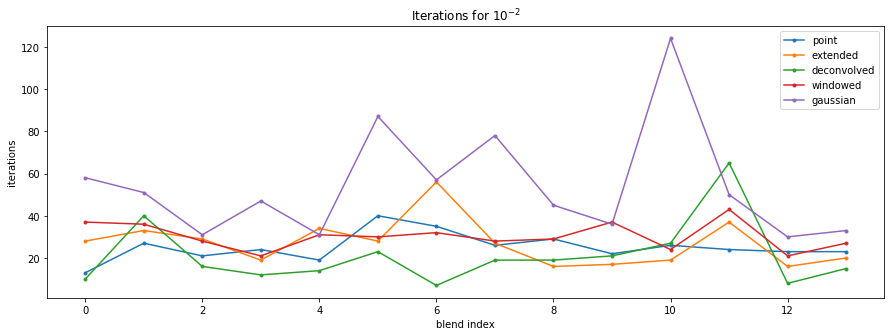

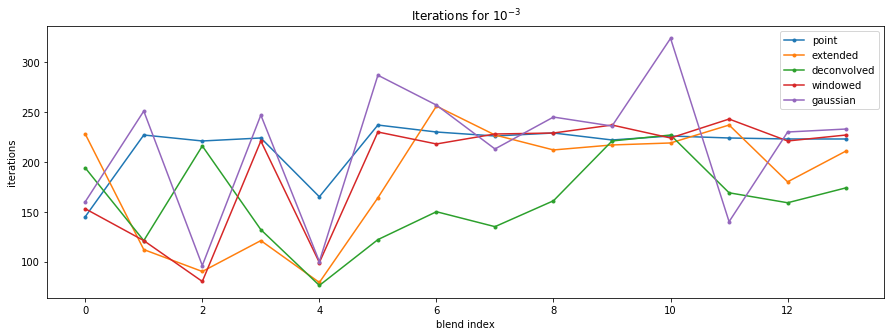

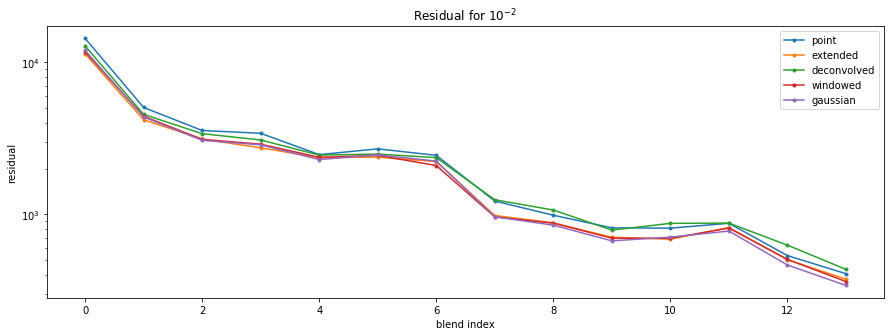

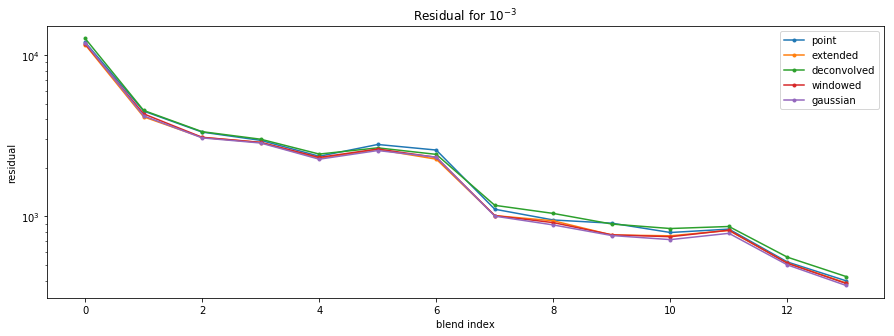

In [5]:
plt.figure(figsize=(15, 5))
for stype, i2 in iterations2.items():
    plt.plot(i2, ".-", label=stype)
plt.title("Iterations for $10^{-2}$")
plt.legend()
plt.xlabel("blend index")
plt.ylabel("iterations")
plt.show()

plt.figure(figsize=(15, 5))
for stype, i3 in iterations3.items():
    plt.plot(i3, ".-", label=stype)
plt.title("Iterations for $10^{-3}$")
plt.legend()
plt.xlabel("blend index")
plt.ylabel("iterations")
plt.show()

plt.figure(figsize=(15, 5))
for stype, r2 in residuals2.items():
    plt.semilogy(r2, ".-", label=stype)
plt.title("Residual for $10^{-2}$")
plt.legend()
plt.xlabel("blend index")
plt.ylabel("residual")
plt.show()

plt.figure(figsize=(15, 5))
for stype, r3 in residuals3.items():
    plt.semilogy(r3, ".-", label=stype)
plt.title("Residual for $10^{-3}$")
plt.legend()
plt.xlabel("blend index")
plt.ylabel("residual")
plt.show()